<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/acgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

# Setup

In [1]:
!nvidia-smi

Mon Jun 14 09:20:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Select the path for current run images, pay attention, old images in the path will be overwritten!

## Drive mount

In [2]:
if False:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [3]:
# for logging train images
if False:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    #runpath = "/content/drive/MyDrive/progetto_asperti/run2"
    #os.makedirs(runpath)


## Imports

In [4]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D, BatchNormalization
import tensorflow.keras.backend as K

from tensorflow.keras.utils import Sequence
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization
from tensorflow_addons.optimizers import AdamW

import random 

import os
import gdown
from zipfile import ZipFile #chose this or !unzip

from tqdm.notebook import tqdm

     |████████████████████████████████| 686kB 7.9MB/s 


## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [5]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Already downloaded")

Download face attributes hosted on public 
github

In [6]:
USE_LABELS = True
if USE_LABELS:
    #!wget -q -O "/content/celeba_gan/list_attr_celeba.txt.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba.txt.zip?raw=true" 
    #!unzip "/content/celeba_gan/list_attr_celeba.txt.zip" -d "/content/celeba_gan"
    #!wget -q -O "/content/celeba_gan/list_attr_celeba.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba.csv.zip?raw=true" 
    #!unzip "/content/celeba_gan/list_attr_celeba.csv.zip" -d "/content/celeba_gan"
    !wget -q -O "/content/celeba_gan/list_attr_celeba01.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba01.csv.zip?raw=true" 
    !unzip -o "/content/celeba_gan/list_attr_celeba01.csv.zip" -d "/content/celeba_gan"
    

Archive:  /content/celeba_gan/list_attr_celeba01.csv.zip
  inflating: /content/celeba_gan/list_attr_celeba01.csv  
  inflating: /content/celeba_gan/__MACOSX/._list_attr_celeba01.csv  


# Keras Dataset 
create Dataset object from our folder, and rescale the images to the [0-1] range:

In [7]:
# image utils functions
def conv_range(in_range=(-1,1), out_range=(0,255)):
    """ Returns range conversion function"""

    # compute means and spans once
    in_mean, out_mean = np.mean(in_range), np.mean(out_range)
    in_span, out_span = np.ptp(in_range), np.ptp(out_range)

    # return function
    def convert_img_range(in_img):
        out_img = (in_img - in_mean) / in_span
        out_img = out_img * out_span + out_mean
        return out_img

    return convert_img_range

def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153]# 128,128 center crop

def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True)

In [8]:
"""5_o_Clock_Shadow,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,
Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,
Eyeglasses,Goatee,Gray_Hair,
Mustache,Narrow_Eyes,No_Beard,Pale_Skin,Receding_Hairline,
Rosy_Cheeks,Sideburns,Straight_Hair,Wearing_Earrings,Wearing_Hat,
Wearing_Necklace,Wearing_Necktie,Young""";

In [33]:
LABELS = [
      "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
      "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"    
]

LABELS = ["Male", "Smiling"]

IMAGE_RANGE = '11' # @param
SHAPE = (64,64,3) # @param
class DataSequence(Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """
    def __init__(self, df, image_directory, batch_size, mode='train',
                 labels = ('Smiling', 'Male'),
                 processing_function = lambda x: x):
        self.df = df # your pandas dataframe
        self.bsz = batch_size # batch size
        self.mode = mode # shuffle when in train mode
        self.im_dir = image_directory
        self.prep_fn = processing_function 
        self.labels = list(labels)

        # Take labels and a list of image locations in memory
        self.labels = self.df[self.labels].values
        self.im_list = self.df['image_id'].tolist()

    def __len__(self):
        # compute number of batches to yield
        return int(math.ceil(len(self.df) / float(self.bsz)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch if in training mode
        self.indexes = range(len(self.im_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return self.labels[idx * self.bsz: (idx + 1) * self.bsz]

    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        return np.array([plt.imread(os.path.join(self.im_dir,im)) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])

    def __getitem__(self, idx):
        #batch_x = resize64(crop128(self.get_batch_features(idx)))
        batch_x = self.prep_fn(self.get_batch_features(idx))
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

df=pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
directory = "/content/celeba_gan/img_align_celeba"
BATCH_SIZE = 128 # @param
N_ATTRIBUTES = len(LABELS)

if IMAGE_RANGE == '01':
    def preprocess_function(img):
        return conv_range((0,255),(0,1))(resize64(crop128(img)))

elif IMAGE_RANGE == '11':
    def preprocess_function(img):
        return conv_range((0,255),(-1,1))(resize64(crop128(img)))

dataset_df = DataSequence(df, directory, BATCH_SIZE, labels=LABELS, 
                          processing_function =  preprocess_function)

In [10]:
N_ATTRIBUTES

2

(TensorShape([32, 64, 64, 3]), 'in range: ', -0.99938726, 1.0000001)

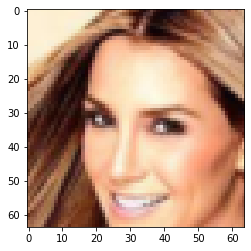

In [11]:
batch = next(iter(dataset_df))
test_img = batch[0][0]

plt.imshow(test_img/2+0.5)
batch[0].shape, "in range: ",np.min(test_img), np.max(test_img)

# Model

## Custom Layers

### Spectral Normalization

In [12]:
from tensorflow.keras import backend as K

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    According to the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        super(SNConv2D, self).__init__(filters, **kwargs)
        self.spectral_normalization = spectral_normalization

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        super(SNConv2DTranspose, self).__init__(**kwargs)
        self.spectral_normalization = spectral_normalization

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

### Pixel Normalization

In [13]:
class PixelNormalization(Layer):
    def __init__(self, epsilon=1e-8,**kwargs):
        self.epsilon = epsilon
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
          #return x / K.sqrt(
           #   K.mean(K.square(x), axis=len(x.shape)-1, keepdims=True) + epsilon)
        return inputs / tf.math.sqrt(
            tf.math.reduce_mean(tf.math.square(inputs), axis=-1, keepdims=True) +self.epsilon)
        
    def compute_output_shape(self, input_shape):
        return input_shape
"""        # Calculate pixel square values
        print(inputs.shape)
        values = inputs**2.0
        # Calculate the mean pixel values
        #mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        mean_values = tf.math.reduce_mean(values, axis=-1, keepdims=True)
        print(mean_values.shape)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized""";


In [14]:
def pixelwise_feature_norm(x, epsilon=1e-8):
  """Pixelwise feature normalization for the output of convolutional layers."""
  return x / K.sqrt(
      K.mean(K.square(x), axis=len(x.shape)-1, keepdims=True) + epsilon)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


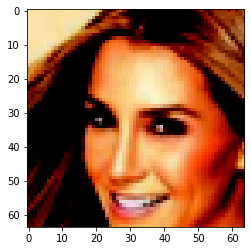

(-0.99938726, 1.0000001, -1.5666701, 1.7156284)

In [15]:
p = PixelNormalization()
batch_img = next(iter(dataset_df))[0]

testimg = batch_img[0]

plt.imshow(testimg)
plt.show()

normalized = p(batch_img)[0]
np.min(testimg), np.max(testimg), np.min(normalized), np.max(normalized)
#plt.imshow()

### Minibatch Standard Deviation

In [16]:
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

## Define Building Functions

In [36]:
def define_original_generator(latent_dim = 100, n_attributes=N_ATTRIBUTES):

    """
    carpedm20's generator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    a fully connected layer and a reshape.
    """

    n_channels_large = 128
    #n_channels_large = 64
    z = keras.Input(shape=(latent_dim,))
    in_attr = layers.Input(shape=(n_attributes))

    z_attr = layers.Concatenate(axis=-1)([z, tf.cast(in_attr, dtype='float32')])

    """ Replaced 
    gen_img = layers.Reshape((1,1,latent_dim))(z)
    # plane shape: (4,4,128*8)
    gen_img = layers.Conv2DTranspose(filters=n_channels_large*8, kernel_size=4,
                                    strides=1, padding='valid',
                                    input_shape=(1,1,100))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)
    # Note that we follow Soumith and place the activation after BN.
    """

    first_plane_shape = (4, 4, n_channels_large*8)
    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(z_attr)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9,
                epsilon=1e-5, scale=True)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    # plane shape: (8,8,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (16,16,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (32,32,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (64,64,3)
    gen_img = layers.Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same',
                      activation='tanh')(gen_img)

    generator = keras.Model(inputs= [z, in_attr], outputs=gen_img )
    return generator

def define_original_discriminator(n_attributes=N_ATTRIBUTES):
    """
    carpedm20's discriminator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    the final layer being diff.
    """

    ndf = 128  # ndf or NDF: Number of Discriminator Filters
    input_img = layers.Input(shape=(64,64,3))

    # plane shape: (32,32,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(input_img)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (16,16,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (8,8,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (4,4,ndf*8)
    d_output_proba = layers.Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    """ Canceled and replaced by what follows it.
    # plane shape: (1,1,1)
    d_output_proba = layers.Conv2D(filters=1, kernel_size=5,
                                  strides=1, padding='valid',
                                  activation='sigmoid')(d_output_proba)
    d_output_proba = layers.Reshape((1,))(d_output_proba)
    """

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)
    out_attr = layers.Dense(n_attributes)(d_output_proba)

    d_output_proba = layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_attr = layers.Activation('sigmoid', name='sigmoid_label')(out_attr)

    discriminator = Model(inputs=input_img, outputs=[d_output_proba, out_attr])
    return discriminator

g = define_original_generator()
d = define_original_discriminator()
g.summary()
d.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf.cast_19 (TFOpLambda)         (None, 2)            0           input_14[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 102)          0           input_13[0][0]                   
                                                                 tf.cast_19[0][0]          

In [ ]:
'''#SN

def define_original_generator(latent_dim = 100, n_attributes=N_ATTRIBUTES):

    """
    carpedm20's generator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    a fully connected layer and a reshape.
    """

    n_channels_large = 128
    #n_channels_large = 64
    z = keras.Input(shape=(latent_dim,))
    in_attr = layers.Input(shape=(n_attributes))

    z_attr = layers.Concatenate(axis=-1)([z, tf.cast(in_attr, dtype='float32')])

    """ Replaced 
    gen_img = layers.Reshape((1,1,latent_dim))(z)
    # plane shape: (4,4,128*8)
    gen_img = layers.Conv2DTranspose(filters=n_channels_large*8, kernel_size=4,
                                    strides=1, padding='valid',
                                    input_shape=(1,1,100))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)
    # Note that we follow Soumith and place the activation after BN.
    """

    first_plane_shape = (4, 4, n_channels_large*8)
    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02),
                          bias_initializer='zeros')(z_attr)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9,
                epsilon=1e-5, scale=True)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    # plane shape: (8,8,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (16,16,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (32,32,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'))(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (64,64,3)
    gen_img = layers.Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same',
                      activation='tanh')(gen_img)

    generator = keras.Model(inputs= [z, in_attr], outputs=gen_img )
    return generator

def define_original_discriminator(n_attributes=N_ATTRIBUTES):
    """
    carpedm20's discriminator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    the final layer being diff.
    """

    #ndf = 64  # ndf or NDF: Number of Discriminator Filters
    ndf = 128
    input_img = layers.Input(shape=(64,64,3))

    # plane shape: (32,32,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(input_img)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (16,16,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (8,8,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (4,4,ndf*8)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'))(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    """ Canceled and replaced by what follows it.
    # plane shape: (1,1,1)
    d_output_proba = layers.Conv2D(filters=1, kernel_size=5,
                                  strides=1, padding='valid',
                                  activation='sigmoid')(d_output_proba)
    d_output_proba = layers.Reshape((1,))(d_output_proba)
    """

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)
    out_attr = layers.Dense(n_attributes)(d_output_proba)

    d_output_proba = layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_attr = layers.Activation('sigmoid', name='sigmoid_label')(out_attr)

    discriminator = Model(inputs=input_img, outputs=[d_output_proba, out_attr])
    return discriminator

g = define_original_generator()
d = define_original_discriminator()
g.summary()
d.summary()'''

In [ ]:
##SN

def define_pxl_generator(latent_dim=128, n_attributes=N_ATTRIBUTES, wgan=False):

    input_latent = layers.Input(shape=(latent_dim,))
    input_attr = layers.Input(shape=(n_attributes))

    x = layers.Concatenate(axis=-1)([input_latent, tf.cast(input_attr, dtype='float32')])

    x = layers.Dense(4 * 4 * 128)(x)
    x = layers.Reshape((4, 4, 128))(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(3, kernel_size=1, padding="same",
                      kernel_initializer="orthogonal", activation="sigmoid")(x)

    return keras.Model(inputs=[input_latent, input_attr], outputs=x,
                       name='generator'+ ('_wgan' if wgan else ''))
    
g = define_pxl_generator(128)
g.summary()

def define_pxl_discriminator(n_attributes = N_ATTRIBUTES, wgan=False):
  
    input = layers.Input(shape=(64, 64, 3))

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)

    out_realfake = layers.Dense(1)(x)
    if wgan:
        out_realfake = layers.Activation('tanh',name='tanh_realfake')(out_realfake)
    else:
        out_realfake = layers.Activation('sigmoid',name='sigmoid_realfake')(out_realfake)
 
    out_label = layers.Dense(n_attributes)(x)

    out_label = layers.Activation('sigmoid', name='sigmoid_label')(out_label)

    discriminator = keras.models.Model(input, [out_realfake, out_label], 
                                       name='discriminator'+ ('_wgan' if wgan else ''))

    return discriminator

d = define_pxl_discriminator(N_ATTRIBUTES)
d.summary()

In [ ]:
def define_std_discriminator(n_attributes = N_ATTRIBUTES, wgan=False):
  
    input = layers.Input(shape=(64, 64, 3))

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)

    out_realfake = layers.Dense(1)(x)
    if wgan:
        out_realfake = layers.Activation('tanh',name='tanh_realfake')(out_realfake)
    else:
        out_realfake = layers.Activation('sigmoid',name='sigmoid_realfake')(out_realfake)
 
    out_label = layers.Dense(n_attributes)(x)

    out_label = layers.Activation('sigmoid', name='sigmoid_label')(out_label)

    discriminator = keras.models.Model(input, [out_realfake, out_label], 
                                       name='discriminator'+ ('_wgan' if wgan else ''))

    return discriminator

def define_std_generator(latent_dim = 128, n_attributes = 40, wgan=False):

    input_latent = layers.Input(shape=(latent_dim,))
    input_attr = layers.Input(shape=(n_attributes))

    x = layers.Concatenate(axis=-1)([input_latent, tf.cast(input_attr, dtype='float32')])
 
    x = layers.Dense(8 * 8 * 128)(x)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(3, kernel_size=5, padding="same")(x)
  
    if wgan:
        x = layers.Activation('tanh',name='tanh')(x)
    else:
        x = layers.Activation('sigmoid',name='sigmoid')(x)

    generator = keras.models.Model([input_latent, input_attr], x, name='generator'+ ('_wgan' if wgan else ''))

    return generator

discriminator = define_std_discriminator(n_attributes=N_ATTRIBUTES)
generator = define_std_generator(n_attributes=N_ATTRIBUTES)
discriminator.summary()
generator.summary()

#### SNPXL

In [ ]:
def define_snpxl_generator(latent_dim=128, n_attributes=N_ATTRIBUTES, wgan=False):

    input_latent = layers.Input(shape=(latent_dim,))
    input_attr = layers.Input(shape=(n_attributes))

    x = layers.Concatenate(axis=-1)([input_latent, tf.cast(input_attr, dtype='float32')])

    x = layers.Dense(4 * 4 * 128*2)(x)
    x = layers.Reshape((4, 4, 128*2))(x)

    x = SNConv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = SNConv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = SNConv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = SNConv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", kernel_initializer="orthogonal")(x)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(3, kernel_size=4, padding="same",
                      kernel_initializer="orthogonal", activation="sigmoid")(x)

    return keras.Model(inputs=[input_latent, input_attr], outputs=x,
                       name='generator'+ ('_wgan' if wgan else ''))
    
g = define_snpxl_generator(128)
g.summary()

def define_snpxl_discriminator(n_attributes = N_ATTRIBUTES, wgan=False):
  
    input = layers.Input(shape=(64, 64, 3))

    x = SNConv2D(filters=128, kernel_size=4,  strides=2, 
                 padding='same', kernel_initializer="orthogonal")(input)

    x = layers.LeakyReLU(alpha=0.2)(x)

    x = SNConv2D(filters=128, kernel_size=4,  strides=2, 
                 padding='same', kernel_initializer="orthogonal")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = SNConv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.Dropout(0.2)(x)

    x = SNConv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.Dropout(0.2)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)

    out_realfake = layers.Dense(1)(x)
    if wgan:
        out_realfake = layers.Activation('tanh',name='tanh_realfake')(out_realfake)
    else:
        out_realfake = layers.Activation('sigmoid',name='sigmoid_realfake')(out_realfake)
 
    out_label = layers.Dense(n_attributes)(x)

    out_label = layers.Activation('sigmoid', name='sigmoid_label')(out_label)

    discriminator = keras.models.Model(input, [out_realfake, out_label], 
                                       name='discriminator'+ ('_wgan' if wgan else ''))

    return discriminator

d = define_snpxl_discriminator(N_ATTRIBUTES)
d.summary()

In [ ]:
# define the standalone discriminator model
def define_discriminator(filters=128, kernel_size=4, strides=(2, 2), in_shape=(64,64,3), in_smooth = True, wgan =False):
    model = keras.Sequential()
    # normal
    #model.add(keras.layers.InputLayer(input_shape = in_shape))
    #model.add(keras.layers.Lambda(lambda x : x + tf.random.normal(shape=in_shape, mean=0.0, stddev=0.01, dtype=tf.float32)))

    model.add(SNConv2D(filters=filters, kernel_size=kernel_size,  strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True, input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 4x4
    model.add(SNConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=True))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(MinibatchStdev())
    model.add(GlobalAveragePooling2D())
    
    # classifier
    model.add(Flatten())
    
    model.add(Dropout(0.4))
    if wgan:
        model.add(Dense(1))
    else:
        model.add(Dense(1, activation='sigmoid'))
    # compile model
    #opt = Adam(lr=0.0002, beta_1=0.5)
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, filters=128, kernel_size=4, strides=(2, 2)):
    model = keras.Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 128)))
    
    # upsample to 8x8
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 64x64
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer 64x64x3
    #model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='tanh', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='sigmoid', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    
    return model

d = define_discriminator()
d.summary()
g = define_generator(128)
g.summary()

In [ ]:
def define_generator(latent_dim):

    model.add(Dense(4* 4* 128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 128)))
    
    # upsample to 8x8
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 64x64
    model.add(SNConv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(PixelNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer 64x64x3
    #model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='tanh', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    model.add(SNConv2D(filters=3, kernel_size=kernel_size, activation='sigmoid', padding='same', kernel_initializer="orthogonal", spectral_normalization=False))
    
    return model

## Define GAN Class
override `train_step`

In [20]:
class ACGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, n_attributes, **kwargs):
        super(ACGAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_attributes = n_attributes# deprecated, take from data

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ACGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

        self.d_realfake_metric = keras.metrics.Mean(name="d_realfake")
        self.d_attr_metric = keras.metrics.Mean(name="d_attr")

        self.g_realfake_metric = keras.metrics.Mean(name="g_realfake")
        self.g_attr_metric = keras.metrics.Mean(name="g_attr")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_attr = data 
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        #n_attributes = real_attr.shape[-1]###### 
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        #random_attr = tf.random.uniform(shape=(batch_size, self.n_attributes), maxval=2, dtype='int64')

        # Decode them to fake images
        #generated_images = self.generator([random_latent_vectors, random_attr])
        # using same real_attr instead of random sampled ones.. is this safe? #########
        generated_images = self.generator([random_latent_vectors, real_attr])

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating fake(1) from real(0) images
        labels_realfake = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        #labels_attr = tf.concat([random_attr, real_attr], axis=0)
        # NON HA SENSO LA LOSS SULLA SECONDA PARTE... OPPURE VA INVERTITA IN BASSO

        labels_attr = tf.concat([real_attr, real_attr], axis=0) #????
        labels_attr = tf.cast(labels_attr, dtype='float32')

        # Add random noise to the labels - important trick!
        labels_realfake = labels_realfake + 0.05 * tf.random.uniform(tf.shape(labels_realfake))
        #labels_attr = labels_attr + 0.05 * tf.random.uniform(tf.shape(labels_attr))

        # Train the discriminator
        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(combined_images)
            pred_real_attr = pred_attr[batch_size: 2*batch_size]

            d_loss_realfake = self.loss_fn(labels_realfake, pred_realfake)
            #print(f"loss_fn({labels_realfake}, {pred_realfake})")
            #print('= ',d_loss_realfake)

            d_loss_attr = self.loss_fn(real_attr, pred_real_attr)#######-1tf.reduce_mean(
            #print(f"loss_fn({labels_attr}, {pred_attr})")
            #print('= ',self.loss_fn(labels_attr, pred_attr))
            #print('reduce_mean -> ',d_loss_attr)

            #print(f"d_loss_realfake: {d_loss_realfake} + d_loss_attr: {d_loss_attr}")
            d_loss = d_loss_realfake + d_loss_attr 
      
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        ## GEN,
        # Sample 2*batch_size so Gen sees the same number of images as Disc

        # Sample NEW random points in the latent space (D has just optimized for previous ones)
        random_latent_vectors = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        # [2*16, 128], [16,2]
        #random_attr = tf.random.uniform(shape=(batch_size, self.n_attributes), maxval=2, dtype='int64')

        # using sampled real attributes during entire training step
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((2*batch_size, 1)) # same as inverting loss sign?

        ##### SHOULD WE SWITCH ATTRIBUTES?!

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(self.generator([random_latent_vectors, labels_attr]))
            g_loss_realfake = self.loss_fn(misleading_labels, pred_realfake)

            #print(f"loss_fn({misleading_labels}, {pred_realfake})")
            #print('= ',g_loss_realfake)

            g_loss_attr = self.loss_fn(labels_attr, pred_attr) ##########tf.reduce_mean(
            #print(f"loss_fn({random_attr}, {pred_attr})")
            #print('= ',self.loss_fn(real_attr, pred_attr))
            #print('reduce_mean -> ',g_loss_attr)

            #print(f"g_loss_realfake: {g_loss_realfake} + g_loss_attr: {g_loss_attr}")
            g_loss = g_loss_realfake + g_loss_attr

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        self.d_realfake_metric.update_state(d_loss_realfake)
        self.d_attr_metric.update_state(d_loss_attr)

        self.g_realfake_metric.update_state(g_loss_realfake)
        self.g_attr_metric.update_state(g_loss_attr)
       
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),

            "d_loss_realfake": self.d_realfake_metric.result(),
            "d_loss_attr": self.d_attr_metric.result(),
            "g_loss_realfake": self.g_realfake_metric.result(),
            "g_loss_attr": self.g_attr_metric.result()

        }


    def call(self, inputs):
        latent, label = inputs
        generated_images = self.generator([latent, label])
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}
        
    def call(self, inputs):
      
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss

# Create callbacks

### Images logger

In [21]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=128, **kwargs):
        super(GANMonitor, self).__init__(**kwargs)
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):#######
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        random_attr = tf.random.uniform(shape=(self.num_img, N_ATTRIBUTES), maxval=2, dtype='int64')

        generated_images = self.model.generator((random_latent_vectors, random_attr))

        generated_images.numpy()
        if IMAGE_RANGE == '11':
            generated_images = conv_range((-1,1), (0,1))(generated_images)

        if ENABLE_WANDB:
            log_images = [wandb.Image(img) for img in generated_images]
            #log_name = f"Epoch {str(epoch)+str(LABELS)+str(random_attr.numpy())}"
            wandb.log({f"Epoch {epoch}": (log_images)})

        fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
        for i, axis in enumerate(axes):
            axis.axis('off')

            axis.title.set_text(f"{[(1-label)*'Not_'+LABELS[i] for i,label in enumerate(random_attr[i])]}")
            axis.imshow(generated_images[i])
        plt.show()

"""    def on_batch_end(self, batch, logs=None):

        freq = 2000
        if (batch+1) % freq == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            random_attr = tf.random.uniform(shape=(self.num_img, N_ATTRIBUTES), maxval=2, dtype='int64')

            generated_images = self.model.generator((random_latent_vectors, random_attr))
            generated_images.numpy()


            fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
            for i, axis in enumerate(axes):
                axis.axis('off')
                axis.title.set_text(f"{[LABELS[label] for label in random_attr[i]]}")
                if IMAGE_RANGE == '11':
                    axis.imshow(range11to01(generated_images[i]))
                else:
                    axis.imshow(generated_images[i])

            fig.set_facecolor((56/255,56/255,56/255))
            plt.show()""";

### Model logger

In [22]:
# log checkpoint artifacts to wandb

SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

class WandbLogger(keras.callbacks.Callback):
    def __init__(self, model_name, run):
        super(WandbLogger, self).__init__()
        assert ENABLE_WANDB == True
        self.model_name = model_name
        self.run = run
        
    def on_epoch_end(self, epoch, logs=None):

        self.model.save(SAVE_PATH + self.model_name, save_format='tf')
        self.artifact = wandb.Artifact(self.model_name, type='model')
        self.artifact.add_dir(SAVE_PATH)
        self.run.log_artifact(self.artifact)


### FID Logger

In [23]:
ENABLE_LOAD = True #@param {type:"boolean"}

project_name = "GAN" #@param {type: "string"}
resume_id = "2hxg7lvr" #@param {type: "string"}
model_name = "mobilenet_2attr" #@param {type: "string"}
experiment_name = "mobilenet_2attr" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

if ENABLE_LOAD:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     id=resume_id, resume=True)

run_name = 'buio/GAN/'+ model_name
artifact_run = run_name +':latest'

artifact = run.use_artifact(artifact_run, type='model')
artifact_dir = artifact.download()
attribute_classifier = tf.keras.models.load_model(os.path.join(artifact_dir, model_name))

attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')
#loss, gen_attr_accuracy = attribute_classifier.evaluate(dataset_df)

run.finish()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


In [34]:
class FIDLogger(keras.callbacks.Callback):
    def __init__(self, real_embeddings, real_attr):
        super(FIDLogger, self).__init__()
        self.real_embeddings = real_embeddings
        self.real_attr = real_attr

    def on_epoch_end(self, epoch, logs=None): # end

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        #generator_prep = define_gen_prep(generator)

        multi_evaluator = define_evaluator(self.model.generator, attribute_classifier)

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
        
        gen_size = 100
        assert FID_COUNT % gen_size == 0

        generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
        pred_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

        for i in tqdm(range(FID_COUNT//gen_size)):
          
            batch_embeddings, batch_attr = multi_evaluator((
                tf.random.normal([gen_size, LATENT_DIM]),
                self.real_attr[i*gen_size:(i+1)*gen_size]))
            
            generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings
            pred_attr[i*gen_size:(i+1)*gen_size] = batch_attr
        
        fid = compute_fid(self.real_embeddings, generated_embeddings)
        acc = np.mean(tf.keras.metrics.binary_accuracy(self.real_attr, pred_attr))

        print("FID: ",fid, "attribute accuracy: ", acc)

        if ENABLE_WANDB:
            wandb.log({'FID': fid})
            wandb.log({'attr_acc': acc})


"""    def on_batch_end(self, batch, logs=None):
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        freq = 200
        if (batch+1) % freq == 0:
            generator_prep = define_gen_prep(self.model.generator)
            FID_COUNT = 10000
            gen_size = 100
            assert FID_COUNT % gen_size == 0

            generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')

            for i in tqdm(range(FID_COUNT//gen_size)):
                batch_embeddings = generator_prep(tf.random.normal([gen_size, LATENT_DIM]))
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

            fid = compute_fid(self.real_embeddings, generated_embeddings)
            print(fid)
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)"""

def define_evaluator(generator, attr_classifier):
    
    img = generator.output
    img = tf.cast(img, tf.float32)

    attributes = attr_classifier(img) # mobilenet model does resizing.. does *2-1 also...

    if IMAGE_RANGE == '01':
        img = img*2 -1

    img_up229 = tf.image.resize(img, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')
    output_repr = inception_model(img_up229)

    multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=[output_repr, attributes])

    return multi_evaluator

def define_gen_prep(generator):

    img = generator.output
    img = tf.cast(img, tf.float32)
    if IMAGE_RANGE == '01':
        img = tf.math.multiply(img,2)
        img = tf.math.add(img, -1)

    img_up = tf.image.resize(img, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')
    output_repr = inception_model(img_up)
    generator_prep = tf.keras.Model(inputs=generator.inputs, outputs=[output_repr])

    return generator_prep

def compute_fid(real_embeddings, generated_embeddings):
    # compute mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # compute sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # compute fid score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [25]:
IMAGE_RANGE = '11' #@param ['01', '11']

In [35]:
#fid
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

def define_real_prep():

    img = layers.Input(shape=SHAPE, name='img_input')
    img_up = tf.image.resize(img, (229, 229), method='bilinear', antialias=True, name='upsample_BILINEAR')
    if IMAGE_RANGE == '01':
        img_up = img_up*2 -1

    output = inception_model(img_up)

    real_prep = tf.keras.Model(inputs=[img], outputs=[output])

    return real_prep

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
real_prep = define_real_prep()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

FID_COUNT = 10000
real_batch_size = 100

fid_real_loader = DataSequence(df, directory, real_batch_size, labels=LABELS, 
                      processing_function =  preprocess_function)
    
    
real_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
real_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

for i in tqdm(range(FID_COUNT//real_batch_size)):
    batch_img, batch_attr = next(iter(fid_real_loader))
    batch_embeddings = real_prep(batch_img)
    real_attr[i*real_batch_size:(i+1)*real_batch_size] = batch_attr
    real_embeddings[i*real_batch_size:(i+1)*real_batch_size] = batch_embeddings


# Training

In [37]:
ADAM_LR_D = 0.00005
ADAM_LR_G = 0.00005
ADAM_B1 = 0.5
ADAM_B2 = 0.999

ENABLE_WANDB = True #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

resume_id = "3buessx3" #@param {type: "string"}
WANDB_RESUME = (resume_id if WANDB_RESUME else False)

project_name = "GAN" #@param {type: "string"}
model_name = "acgan_2attr_bs128" #@param {type: "string"}
experiment_name = "acgan_2attr_bs128" #@param {type: "string"}
run_notes = "" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

from keras.callbacks import ModelCheckpoint
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, name=experiment_name, resume=WANDB_RESUME)
    if run_notes:
        wandb.notes = run_notes
    wandb.config.batch_size = BATCH_SIZE
    wandb.config.adam_lr_d = ADAM_LR_D
    wandb.config.adam_lr_g = ADAM_LR_G
    wandb.config.adam_b1 = ADAM_B1
    wandb.config.adam_b2 = ADAM_B2
    wandb.config.img_range = IMAGE_RANGE
    wandb.config.n_attributes = N_ATTRIBUTES

wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


d_loss,0.27917
g_loss,2.88307
d_loss_realfake,0.41996
d_loss_attr,0.08284
g_loss_realfake,2.02124
g_loss_attr,0.02886
_runtime,19582
_timestamp,1623682248
_step,9908
epoch,14
FID,121.42549


d_loss,▅▄▄▅▅▇▇▇██████████▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
g_loss,█▇▆▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄
d_loss_realfake,▁▂▂▃▄▄▅▅▆▆▇▇▇▇▇███████████████▇▇▇▇▇▇▇▇▇▆
d_loss_attr,█▇▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
g_loss_realfake,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
g_loss_attr,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
FID,█▃▃▂▁▁▂▁▁▁▁▁▁▁▁


## Build the WGAN Model

In [35]:
if False:
    # Instantiate the optimizer for both networks
    # (learning_rate=0.0002, beta_1=0.5 are recommended)
    generator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9
    )
    discriminator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9
    )

    # Define the loss functions for the discriminator,
    # which should be (fake_loss - real_loss).
    # We will add the gradient penalty later to this loss function.
    def discriminator_loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss


    # Define the loss functions for the generator.
    def generator_loss(fake_img):
        return -tf.reduce_mean(fake_img)

    LATENT_DIM = 128

    discriminator = define_discriminator(wgan=True)
    generator = define_generator(latent_dim = LATENT_DIM)

    # Instantiate the WGAN model.
    wgan = WGAN(
        discriminator=discriminator,
        generator=generator,
        latent_dim=LATENT_DIM,
        discriminator_extra_steps=3,
    )

    # Compile the WGAN model.
    wgan.compile(
        d_optimizer=discriminator_optimizer,
        g_optimizer=generator_optimizer,
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
    )


    # build model for saving
    images, d_loss = wgan.predict(tf.random.normal(shape=(1, LATENT_DIM)))
    plt.imshow(images[0])
    print(images.shape, d_loss)
    wgan.save('models/'+model_name+experiment_name, save_format='tf')


## Build the ACGAN Model

In [38]:
LATENT_DIM = 100

discriminator = define_original_discriminator(n_attributes=N_ATTRIBUTES)
generator = define_original_generator(latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)

acgan = ACGAN(discriminator, generator, latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)

acgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_D, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    g_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_G, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    loss_fn=keras.losses.BinaryCrossentropy()#label_smoothing=0.1)
)

# build model for saving

random_latent_vectors = tf.random.normal(shape=(1, LATENT_DIM))
random_attr = tf.random.uniform(shape=(1, N_ATTRIBUTES), maxval=2, dtype='int64')

images, d_loss = acgan.predict((random_latent_vectors, random_attr))
print(images.shape, d_loss, np.min(images), np.max(images))
acgan.save('models/'+model_name+experiment_name, save_format='tf')

(1, 64, 64, 3) [array([[0.5014255]], dtype=float32), array([[0.50079846, 0.49950588]], dtype=float32)] -0.108112656 0.14329109


In [37]:
if WANDB_RESUME:
    run_name = 'buio/GAN/'+ model_name + experiment_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    acgan.load_weights(os.path.join(artifact_dir, model_name + experiment_name))


wandb: Downloading large artifact acgan_2attracgan_2attr:latest, 415.47MB. 4 files... Done. 0:0:0


## Train

Epoch 1/200
1583/1583 [==============================] - 892s 561ms/step - d_loss: 0.4854 - g_loss: 4.6002 - d_loss_realfake: 0.2395 - d_loss_attr: 0.3312 - g_loss_realfake: 3.9413 - g_loss_attr: 0.6430


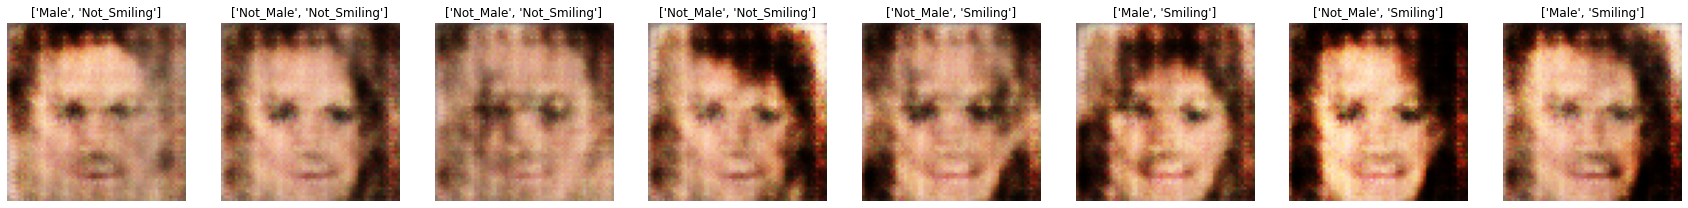

wandb: Adding directory to artifact (./models)... Done. 2.9s


In [ ]:
epochs = 200  # In practice, use ~100 epochs

acgan.fit(dataset_df, epochs=epochs, 
        #initial_epoch=10, 
        #steps_per_epoch=20,
        callbacks=[
            WandbCallback(log_batch_frequency=10, verbose=1),
            GANMonitor(num_img=8, latent_dim=LATENT_DIM),
            WandbLogger(model_name+experiment_name, run=run),
            FIDLogger(real_embeddings, real_attr)
            ]
)

In [39]:
run.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd99098aed0>> (for pre_run_cell):


Exception: ignored

Exception: ignored

In [ ]:
# INVERT GENERATOR LABELS?? SO THAT THE DISCRIMINATOR HEAD CAN LEARN GENERETAR ATTEMPTS TO LABELS!
# BUT THE GENERATOR IS SO GOOD!

# Losses


Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)